In [1]:
# !pip install graphviz -q
from graphviz import Digraph
import random
import math
import matplotlib.pyplot as plt

In [2]:
class Value:
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
			
	def __repr__(self):
		return f"Value(data={self.data})"

	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')
		
		def _backward():
			self.grad += 1* out.grad
			other.grad += 1* out.grad
		out._backward = _backward

		return out

	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')
		
		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward
		
		return out
	
	def __pow__(self, other):
		assert isinstance(other, (int, float)), "only supporting int/float for now"
		out = Value(self.data**other, (self,), f'**{other}')

		def _backward():
			self.grad += other * self.data**(other-1) * out.grad
		out._backward = _backward

		return out
	
	def exp(self):
		out = Value(math.exp(self.data), (self,), 'exp')

		def _backward():
			self.grad += math.exp(self.data) * out.grad
		out._backward = _backward

		return out
	
	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
		out = Value(t, (self,), 'tanh')

		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward
		
		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)

		self.grad = 1.0
		for node in reversed(topo):
			node._backward()


	def __neg__(self):
		return self * -1
	
	def __radd__(self, other):
		return self + other
	
	def __sub__(self, other):
		return self + (-other)

	def __rsub__(self, other):
		return other + (-self)
	
	def __rmul__(self, other):
		return self * other
	
	def __truediv__(self, other):
		return self * other**-1

### Graphviz Visualization Code

In [3]:
def trace(root):
	# builds a set of all nodes and edges in a graph
	nodes, edges = set(), set()
	def build(v):
		if v not in nodes:
			nodes.add(v)
			for child in v._prev:
				edges.add((child, v))
				build(child)
	build(root)
	return nodes, edges

def draw_dot(root):
	dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = Left to right

	nodes, edges = trace(root)  # get nodes and edges of the graph
	for n in nodes:
		uid = str(id(n))
		# for any value in the graph, create a rectangular ('record') node for it
		dot.node(name = uid, label = f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
		if n._op:
			# if this value is a result of some operation, create an op node for it
			dot.node(name = uid + n._op, label = n._op)
			# and connect this node to it
			dot.edge(uid + n._op, uid)

	for n1, n2 in edges:
		# connect n1 to the op node of n2
		dot.edge(str(id(n1)), str(id(n2)) + n2._op)

	return dot

### Example of Variable Being Part of Different Operations

The code below demonstrates how variables can be part of different operations in a computational graph. We define new variables `a` and `b`, perform operations on them, and then visualize the resulting computational graph.


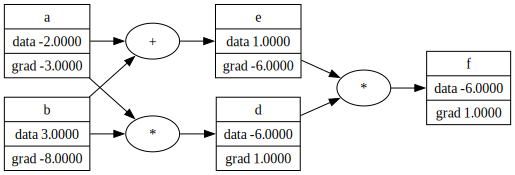

In [4]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a+ b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

## Single Neuron

In [5]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

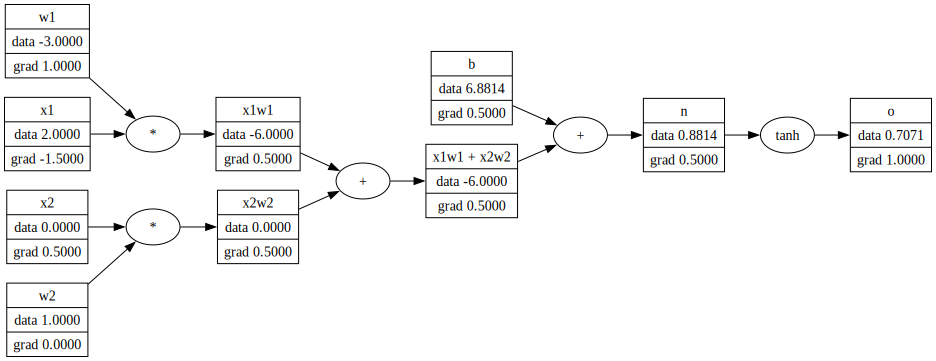

In [6]:
o.backward()
draw_dot(o)

### Using PyTorch

In [7]:
import torch

In [8]:
x1 = torch.tensor(2.0, requires_grad=True, dtype=torch.float64)
x2 = torch.tensor(0.0, requires_grad=True, dtype=torch.float64)
w1 = torch.tensor(-3.0, requires_grad=True, dtype=torch.float64)
w2 = torch.tensor(1.0, requires_grad=True, dtype=torch.float64)
b = torch.tensor(6.88137, requires_grad=True, dtype=torch.float64)

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x1", x1.grad.item())
print("x2", x2.grad.item())
print("w1", w1.grad.item())
print("w2", w2.grad.item())
print("b", b.grad.item())


0.7071049876722272
---
x1 -1.5000076092271784
x2 0.5000025364090595
w1 1.000005072818119
w2 0.0
b 0.5000025364090595


## MLP

In [9]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), 0.0) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


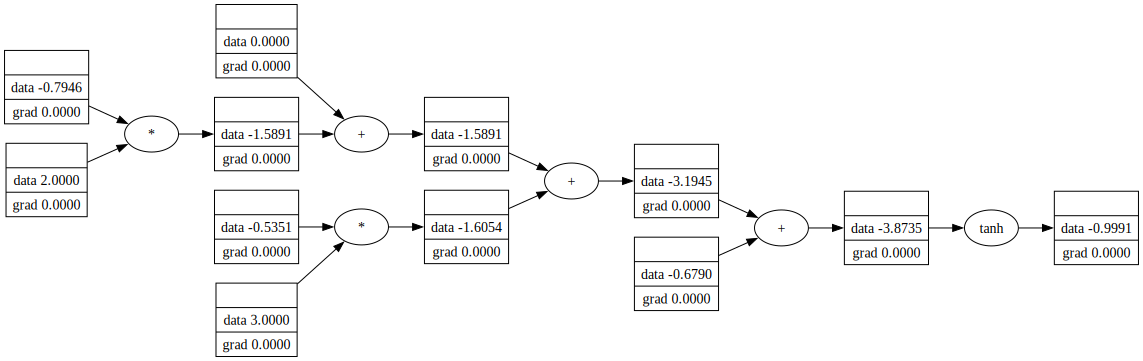

In [16]:
x = [2.0, 3.0]
y = MLP(2, [1])(x)
y
draw_dot(y)

## Testing on a small dataset

In [11]:
n = MLP(3, [4, 4, 1])

In [12]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [-1.0, 0.5, 2.0],
    [0.5, 2.0, 3.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [13]:
len(n.parameters())

41

In [14]:
losses = []
for _ in range(1, 51):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yi - ypi)**2 for yi, ypi in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update weights
    for p in n.parameters():
        p.data -= 0.05 * p.grad
    losses.append(loss.data)
    
    if _ % 10 == 0:
        print(f"Epoch {_}, Loss {loss.data}")
    # print(ypred)

Epoch 10, Loss 0.19440158931189613
Epoch 20, Loss 0.07789365334201608
Epoch 30, Loss 0.04688168755897455
Epoch 40, Loss 0.03299357746339144
Epoch 50, Loss 0.0252290246319666


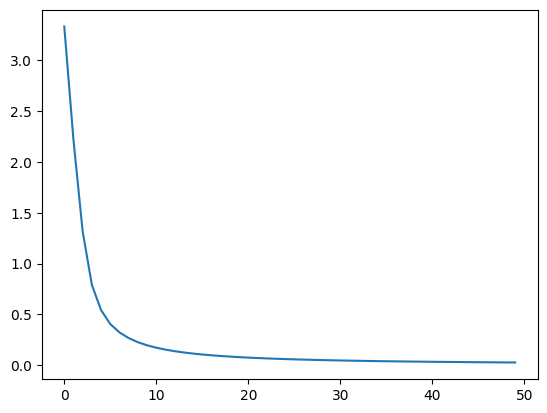

0.9440413512066559 -0.9176583973976059 -0.9131751536042264 0.9118015828576868


0.0252290246319666

In [15]:
plt.plot(losses)
plt.show()
print(*[yp.data for yp in ypred])
loss.data